In [1]:
!pip install git+https://github.com/leymir/hyperbolic-image-embeddings.git #Install hyptorch
!pip install torch numpy matplotlib scikit-learn geomstats
!pip install tsne-torch

import time
import torch
import warnings
import geomstats
import tsne_torch
import numpy as np
import torch as th
import seaborn as sns
import scipy.stats as stats
import hyptorch.pmath as pmath
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import linalg
from sklearn.manifold import TSNE
from sklearn.manifold import _utils
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator
from scipy.spatial.distance import pdist
from sklearn.datasets import fetch_openml
from sklearn.utils import check_random_state
from scipy.spatial.distance import squareform
from scipy.sparse import csr_matrix, issparse
from sklearn.manifold import _barnes_hut_tsne
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from geomstats.geometry.hyperbolic import Hyperbolic
from geomstats.geometry.hypersphere import Hypersphere
from sklearn.utils.validation import check_non_negative
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.utils._openmp_helpers import _openmp_effective_n_threads

MACHINE_EPSILON = np.finfo(np.double).eps

print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.get_device_name()}")
    print(f"Device count: {torch.cuda.device_count()}")

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

sns.set_style("whitegrid")
plt.style.use('default')

  Cloning https://github.com/leymir/hyperbolic-image-embeddings.git to /tmp/pip-req-build-mn5ib3bm
  Running command git clone --filter=blob:none --quiet https://github.com/leymir/hyperbolic-image-embeddings.git /tmp/pip-req-build-mn5ib3bm
  Resolved https://github.com/leymir/hyperbolic-image-embeddings.git to commit 6633edbbeffd6d90271f0963852a046c64f407d6
  Preparing metadata (setup.py) ... done
  Created wheel for hyptorch: filename=hyptorch-1.0.0-py3-none-any.whl size=8175 sha256=3d0e5411174a6aea27f2edbfac239473cb6ad7d07ad1ee84093a2885a6b1bccf
  Stored in directory: /tmp/pip-ephem-wheel-cache-klmvd__0/wheels/fc/87/db/9478805eaf82857919ad1f6cbf32f6efbe19eb7c2aab3fa486
Successfully built hyptorch
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 102.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tsne-torch: filename=tsne_torch-1.0.1-py3-none-any.whl size=5597 sha256=72f4c1fd0a0a9428e7c0f3ad68414d1d9536e3ac6165c36b5d8a8302cacfe64f
  Stored in di

INFO:numexpr.utils:NumExpr defaulting to 12 threads.


CUDA available: True
Current device: NVIDIA A100-SXM4-40GB
Device count: 1


**Visualizing Mixed-Curvature Data Through Geometric Decomposition**

In [2]:
def euclidean_distance(x, y):
    """Compute Euclidean distance between points."""
    return np.sqrt(np.sum((x - y) ** 2, axis=-1))

def hyperbolic_distance(x, y, manifold=None):
    """Compute hyperbolic distance between points."""
    if manifold is None:
        manifold = Hyperbolic(dim=x.shape[-1]-1)  # -1 for Poincare ball model
    return manifold.dist(x, y)

def spherical_distance(x, y, manifold=None):
    """Compute spherical distance between points."""
    if manifold is None:
        manifold = Hypersphere(dim=x.shape[-1]-1)
    return manifold.dist(x, y)

class ProductSpace:
    """
    Manages combinations of different geometric spaces (Euclidean, Hyperbolic, Spherical).
    Provides functionality for data generation and manipulation in mixed-curvature spaces.
    """
    def __init__(self, signature=[], X=None, y=None, seed=None):
        """
        Initialize ProductSpace with signature defining the component spaces

        Parameters:
        -----------
        signature : list of tuples
            List of (dimension, curvature) tuples defining each component space
        X : array-like
            Input data (optional)
        y : array-like
            Labels (optional)
        seed : int
            Random seed
        """
        self.signature = signature
        self.check_signature()
        self.X = X
        self.y = y
        self.seed = seed

    def check_signature(self):
        """Check if signature is valid"""
        if len(self.signature) == 0:
            raise ValueError("Signature is empty")
        for space in self.signature:
            if not isinstance(space, tuple):
                raise ValueError("Signature elements must be tuples")
            if len(space) != 2:
                raise ValueError("Signature tuples must have 2 values")
            if not isinstance(space[0], int) or space[0] <= 0:
                raise ValueError("Dimension must be a positive integer")
            if not isinstance(space[1], (int, float)):
                raise ValueError("Curvature must be an integer or float")

    def print_signature(self):
        """Print the signature of the product space"""
        for space in self.signature:
            if space[1] < 0:
                print(f"H: dim={space[0]}, K={space[1]}")
            elif space[1] > 0:
                print(f"S: dim={space[0]}, K={space[1]}")
            else:
                print(f"E: dim={space[0]}")

    def sample_clusters(self, num_points, num_classes, cov_scale=0.3, centers=None):
        """Generate data from a wrapped normal mixture on the product space"""
        self.X, self.y, self.means = [], [], []
        classes = WrappedNormalMixture(
            num_points=num_points, num_classes=num_classes, seed=self.seed
        ).generate_class_assignments()

        for space in self.signature:
            wnm = WrappedNormalMixture(
                num_points=num_points,
                num_classes=num_classes,
                n_dim=space[0],
                curvature=space[1],
                seed=self.seed,
                cov_scale=cov_scale,
            )
            means = wnm.generate_cluster_means(centers=centers)
            covs = [
                wnm.generate_covariance_matrix(wnm.n_dim, wnm.n_dim + 1, wnm.cov_scale)
                for _ in range(wnm.num_classes)
            ]
            points = wnm.sample_points(means, covs, classes)
            means /= np.sqrt(wnm.k) if wnm.k != 0.0 else 1.0
            self.X.append(points)
            self.y.append(classes)
            self.means.append(means)
            if wnm.curvature != 0.0:
                assert np.allclose(wnm.manifold.metric.squared_norm(points), 1 / wnm.curvature, rtol=1e-4)

        self.X = np.hstack(self.X)  # (num_points, num_spaces * (num_dims+1))
        self.y = self.y[0]  # (num_points,)
        self.means = np.hstack(self.means)  # (num_classes, num_dims + 1)

    def split_data(self, test_size=0.2):
        """Split the data into training and testing sets"""
        n = self.X.shape[0]
        np.random.seed(self.seed)
        test_idx = np.random.choice(n, int(test_size * n), replace=False)
        self.X_train = np.delete(self.X, test_idx, axis=0)
        self.X_test = self.X[test_idx]
        self.y_train = np.delete(self.y, test_idx)
        self.y_test = self.y[test_idx]

    def zero_out_spacelike_dims(self, space_idx):
        """Zero out spacelike dimensions in a given product space component"""
        timelike_dim = sum([space[0] + 1 for space in self.signature[:space_idx]])
        self.X[:, timelike_dim] = 1.0 / np.sqrt(abs(self.signature[space_idx][1]))
        for i in range(self.signature[space_idx][0]):
            self.X[:, timelike_dim + i + 1] = 0.0

    def remove_timelike_dims(self):
        """Remove timelike dimensions from the product space"""
        timelike_dims = [0]
        for i in range(len(self.signature) - 1):
            timelike_dims.append(sum([space[0] + 1 for space in self.signature[: i + 1]]))
        self.X = np.delete(self.X, timelike_dims, axis=1)

class WrappedNormalMixture:
    """
    Generates synthetic data from wrapped normal distributions in different geometries.
    Supports Euclidean, Hyperbolic, and Spherical spaces.
    """
    def __init__(
        self,
        num_points: int,
        num_classes: int,
        n_dim: int = 2,
        curvature: float = 0.0,
        seed: int = None,
        cov_scale: float = 0.3,
    ):
        """
        Initialize wrapped normal mixture model.

        Parameters:
        -----------
        num_points: Total number of points to generate
        num_classes: Number of mixture components
        n_dim: Dimension of the space
        curvature: Geometric curvature (negative=hyperbolic, 0=Euclidean, positive=spherical)
        seed: Random seed for reproducibility
        cov_scale: Scale factor for covariance matrices
        """
        self.num_points = num_points
        self.num_classes = num_classes
        self.n_dim = n_dim
        self.curvature = curvature
        self.k = abs(curvature)
        self.curv_sign = 1
        self.seed = seed
        self.cov_scale = cov_scale

        # Set random number generator
        self.rng = np.random.default_rng(self.seed)

        # Set manifold based on curvature
        if curvature == 0.0:
            self.manifold = Euclidean(dim=n_dim)
        elif curvature > 0.0:
            self.manifold = Hypersphere(dim=n_dim)
        else:
            self.manifold = Hyperboloid(dim=n_dim)
            self.curv_sign = -1

        # Set origin for hyperboloid and hypersphere
        self.origin = np.array([1.0] + [0.0] * self.n_dim)

    def generate_cluster_means(self, centers=None):
        """Generate random cluster means or given cluster means on the manifold, adjusted for curvature."""
        if centers is None:
            centers = self.rng.normal(size=(self.num_classes, self.n_dim))
        means = np.concatenate(
            (
                np.zeros(shape=(self.num_classes, 1)),
                centers,
            ),
            axis=1,
        )
        means *= np.sqrt(self.k) if self.k != 0.0 else 1.0
        return self.manifold.metric.exp(tangent_vec=means, base_point=self.origin)

    def generate_covariance_matrix(self, dims, deg_freedom, scale):
        """Generate random covariance matrix"""
        scale_matrix = scale * np.eye(dims)
        cov_matrix = wishart.rvs(df=deg_freedom, scale=scale_matrix, random_state=self.rng)
        return cov_matrix

    def generate_class_assignments(self):
        """Generate random class assignments"""
        probs = self.rng.uniform(size=self.num_classes)
        probs = probs / np.sum(probs)
        return self.rng.choice(self.num_classes, size=self.num_points, p=probs)

    def sample_points(self, means, covs, classes):
        """Generate random samples for each cluster"""
        vecs = np.array([
            self.rng.multivariate_normal(np.zeros(self.n_dim), covs[c])
            for c in classes
        ])

        vecs *= np.sqrt(self.k) if self.k != 0.0 else 1.0
        vecs = np.column_stack((np.zeros(vecs.shape[0]), vecs))

        tangent_vecs = self.manifold.metric.parallel_transport(
            vecs, self.origin, end_point=means[classes]
        )

        points = self.manifold.metric.exp(
            tangent_vec=tangent_vecs, base_point=means[classes]
        )

        points /= np.sqrt(abs(self.k)) if self.k != 0.0 else 1.0
        return points

    def generate_data(self):
        """Generate Gaussian mixture data"""
        means = self.generate_cluster_means()
        covs = [
            self.generate_covariance_matrix(self.n_dim, self.n_dim + 1, self.cov_scale)
            for _ in range(self.num_classes)
        ]
        classes = self.generate_class_assignments()
        points = self.sample_points(means, covs, classes)
        means /= np.sqrt(self.k) if self.k != 0.0 else 1.0
        return points, classes, means

In [3]:
def _joint_probabilities(distances, desired_perplexity, verbose):
    """Compute joint probabilities for t-SNE"""
    distances = distances.astype(np.float32, copy=False)
    conditional_P = _utils._binary_search_perplexity(
        distances, desired_perplexity, verbose)
    P = conditional_P + conditional_P.T
    sum_P = np.maximum(np.sum(P), MACHINE_EPSILON)
    P = np.maximum(squareform(P) / sum_P, MACHINE_EPSILON)
    return P

def _joint_probabilities_nn(distances, desired_perplexity, verbose):
    """Compute joint probabilities for t-SNE with nearest neighbors"""
    t0 = time()
    distances.sort_indices()
    n_samples = distances.shape[0]
    distances_data = distances.data.reshape(n_samples, -1)
    distances_data = distances_data.astype(np.float32, copy=False)
    conditional_P = _utils._binary_search_perplexity(
        distances_data, desired_perplexity, verbose)
    assert np.all(np.isfinite(conditional_P)), \
        "All probabilities should be finite"

    P = csr_matrix((conditional_P.ravel(), distances.indices,
                    distances.indptr),
                   shape=(n_samples, n_samples))
    P = P + P.T

    sum_P = np.maximum(P.sum(), MACHINE_EPSILON)
    P /= sum_P

    assert np.all(np.abs(P.data) <= 1.0)
    if verbose >= 2:
        duration = time() - t0
        print("[t-SNE] Computed conditional probabilities in {:.3f}s"
              .format(duration))
    return P

def hdist_grad(x, v, sqnormx, sqnormv, sqdist, eps):
    """Compute gradient of hyperbolic distance"""
    alpha = (1 - sqnormx)
    beta = (1 - sqnormv)
    z = 1 + 2 * sqdist / (alpha * beta)
    a = ((sqnormv - 2 * th.sum(x * v, dim=-1) + 1) / th.pow(alpha, 2))\
        .unsqueeze(-1).expand_as(x)
    a = a * x - v / alpha.unsqueeze(-1).expand_as(v)
    z = th.sqrt(th.pow(z, 2) - 1)
    z = th.clamp(z * beta, min=eps).unsqueeze(-1)
    return 4 * a / z.expand_as(x)

def _kl_divergence(params, P, embs, learning_rate_for_h_loss, degrees_of_freedom, n_samples, n_components,
                   skip_num_points=0, compute_error=True, student_t_gamma=1.0):
    """Compute KL divergence and gradients for t-SNE optimization"""
    X_embedded = params.reshape(n_samples, n_components)

    # Use hyperbolic distance for calculating Q
    X_tensor = th.from_numpy(X_embedded)
    dist = pmath.dist_matrix(X_tensor, X_tensor, c=1)
    dist = dist / (student_t_gamma**2)
    dist = squareform(dist.numpy(), checks=False)
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    square_dist = squareform(dist)
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)
    square_Q = squareform(Q)

    # Cost for maintaining magnitude
    mag_cost = np.mean((np.linalg.norm(embs, axis=1)**2 - np.linalg.norm(X_embedded, axis=1)**2)**2)
    mag_grad_scale = (-4 * (np.linalg.norm(embs, axis=1)**2 - np.linalg.norm(X_embedded, axis=1)**2))
    mag_grad = mag_grad_scale[:,np.newaxis] * X_embedded

    if compute_error:
        kl_divergence = 2.0 * np.dot(
            P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    else:
        kl_divergence = np.nan

    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist)
    grad_per_point = np.ndarray((n_samples, n_samples, n_components))
    grad_sign = np.ndarray((n_samples, n_samples))
    y_j_norms = np.linalg.norm(X_embedded, axis=1)
    beta = 1. - y_j_norms

    for i in range(skip_num_points, n_samples):
        alpha = 1. - np.linalg.norm(X_embedded[i])
        alphabeta = alpha * beta
        gamma = 1 + ((2. / alphabeta) * (np.linalg.norm(X_embedded[i] - X_embedded, axis = 1) ** 2.))
        dot_products = np.dot(X_embedded, X_embedded[i])
        com1 = (4. / (beta * np.sqrt(gamma**2. - 1. + 1e-10)))
        com2 = (np.outer((y_j_norms**2. - 2.*dot_products + 1.) / (alpha**2. + 1e-5), X_embedded[i])  - X_embedded/alpha)
        dd_dy = com1[:, np.newaxis] * com2
        dim_ = dd_dy[i].shape[0]
        dd_dy[i] = [0] * dim_
        grad[i] = np.sum(PQd[i][:, np.newaxis] * dd_dy,axis=0)
        grad_sign[i] = np.sign(np.ravel(PQd[i]))
        grad_per_point[i] = np.ravel(PQd[i], order='K')[:, np.newaxis] * dd_dy

    grad = ((1. - np.linalg.norm(X_embedded, axis=1) ** 2) ** 2)[:, np.newaxis] * grad / 4
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c

    split_cost = (kl_divergence, mag_cost, np.linalg.norm(grad), np.linalg.norm(mag_grad))
    grad = grad.ravel()
    mag_grad = mag_grad.ravel()

    return kl_divergence + mag_cost, grad, learning_rate_for_h_loss*mag_grad, split_cost, grad_per_point, grad_sign

def _gradient_descent(objective, p0, it, n_iter,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-8, verbose=0, args=None, kwargs=None):
    """Batch gradient descent with momentum and individual gains."""
    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(float).max
    best_error = np.finfo(float).max
    best_iter = i = it

    split_errors = []
    errors = []
    grads = []
    output_embs = []
    grad_pers = []
    grad_signs = []
    tic = time()

    for i in range(it, n_iter):
        if i % 10 == 0 or i < 10:
            output_embs.append((i, p))

        check_convergence = (i + 1) % n_iter_check == 0
        kwargs['compute_error'] = True

        error, grad, mag_grad, split_error, grad_per_point, grad_sign = objective(p, *args, **kwargs)

        errors.append(error)
        grads.append(grad)
        split_errors.append(split_error)
        grad_pers.append(grad_per_point)
        grad_signs.append(grad_sign)
        grad_norm = linalg.norm(grad)

        momentum = 0.0
        update = -learning_rate * grad - mag_grad
        p += update

        X_embed = p.reshape((-1, 2))
        for j in range(X_embed.shape[0]):
            x_len = np.linalg.norm(X_embed[j])
            if x_len > 1:
                X_embed[j] = (X_embed[j] / x_len) - 1e-5

        p = X_embed.flatten()

        if check_convergence:
            toc = time()
            duration = toc - tic
            tic = toc

            if verbose >= 2:
                print("[HT-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      " (%s iterations in %0.3fs)"
                      % (i + 1, error, grad_norm, n_iter_check, duration))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: did not make any progress "
                          "during the last %d episodes. Finished."
                          % (i + 1, n_iter_without_progress))
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                          % (i + 1, grad_norm))
                break

    return p, error, i, errors, output_embs, split_errors, grads, grad_pers, grad_signs

In [4]:
class TSNE(BaseEstimator):
    """
    t-SNE dimensionality reduction with support for different geometries.
    This implementation includes support for hyperbolic geometry (CO-SNE).
    """
    # Control the number of exploration iterations with early_exaggeration on
    _EXPLORATION_N_ITER = 500

    # Control the number of iterations between progress checks
    _N_ITER_CHECK = 50

    @_deprecate_positional_args
    def __init__(self, n_components=2, *, perplexity=30.0,
                 early_exaggeration=12.0, learning_rate=200.0, n_iter=1000,
                 learning_rate_for_h_loss=1.0, student_t_gamma=1.0,
                 n_iter_without_progress=300, min_grad_norm=1e-7,
                 metric="euclidean", init="random", verbose=0,
                 random_state=None, method='barnes_hut', angle=0.5,
                 n_jobs=None, square_distances='legacy'):
        self.n_components = n_components
        self.perplexity = perplexity
        self.early_exaggeration = early_exaggeration
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.n_iter_without_progress = n_iter_without_progress
        self.min_grad_norm = min_grad_norm
        self.metric = metric
        self.init = init
        self.verbose = verbose
        self.random_state = random_state
        self.method = method
        self.angle = angle
        self.n_jobs = n_jobs
        self.square_distances = square_distances
        self.learning_rate_for_h_loss = learning_rate_for_h_loss
        self.student_t_gamma = student_t_gamma

    def _fit(self, X, embs, skip_num_points=0):
        """Private function to fit the model using X as training data."""
        if self.method not in ['barnes_hut', 'exact']:
            raise ValueError("'method' must be 'barnes_hut' or 'exact'")
        if self.angle < 0.0 or self.angle > 1.0:
            raise ValueError("'angle' must be between 0.0 - 1.0")
        if self.square_distances not in [True, 'legacy']:
            raise ValueError("'square_distances' must be True or 'legacy'.")
        if self.metric != "euclidean" and self.square_distances is not True:
            warnings.warn("The square_distances parameter will be deprecated in version 1.3", FutureWarning)

        # Validate input data
        if self.method == 'barnes_hut':
            X = self._validate_data(X, accept_sparse=['csr'],
                                  ensure_min_samples=2,
                                  dtype=[np.float32, np.float64])
        else:
            X = self._validate_data(X, accept_sparse=['csr', 'csc', 'coo'],
                                  dtype=[np.float32, np.float64])

        if self.metric == "precomputed":
            if isinstance(self.init, str) and self.init == 'pca':
                raise ValueError("The parameter init=\"pca\" cannot be used with metric=\"precomputed\".")
            if X.shape[0] != X.shape[1]:
                raise ValueError("X should be a square distance matrix")
            if self.method == "exact" and issparse(X):
                raise TypeError('TSNE with method="exact" does not accept sparse precomputed distance matrix.')

        if self.method == 'barnes_hut' and self.n_components > 3:
            raise ValueError("'n_components' should be inferior to 4 for the barnes_hut algorithm.")

        random_state = check_random_state(self.random_state)

        if self.early_exaggeration < 1.0:
            raise ValueError("early_exaggeration must be at least 1")

        n_samples = X.shape[0]

        # Initialize the embedding
        if isinstance(self.init, np.ndarray):
            X_embedded = self.init
        elif self.init == 'pca':
            pca = PCA(n_components=self.n_components, svd_solver='randomized',
                      random_state=random_state)
            X_embedded = pca.fit_transform(X).astype(np.float32, copy=False)
        elif self.init == 'random':
            X_embedded = 0.01 * random_state.randn(
                n_samples, self.n_components).astype(np.double)
            X_embedded = pmath.project(th.from_numpy(X_embedded)).numpy()
        else:
            raise ValueError("'init' must be 'pca', 'random', or a numpy array")

        # Compute the joint probability distribution for the input space
        if self.method == 'exact':
            distances = pairwise_distances(X, metric=self.metric) if self.metric != "precomputed" else X
            P = _joint_probabilities(distances, self.perplexity, self.verbose)
        else:
            n_neighbors = min(n_samples - 1, int(3. * self.perplexity + 1))
            knn = NearestNeighbors(algorithm='auto', n_jobs=self.n_jobs,
                                  n_neighbors=n_neighbors, metric=self.metric)
            knn.fit(X)
            distances_nn = knn.kneighbors_graph(mode='distance')
            del knn
            P = _joint_probabilities_nn(distances_nn, self.perplexity, self.verbose)

        degrees_of_freedom = max(self.n_components - 1, 1)

        return self._tsne(P, degrees_of_freedom, n_samples,
                         X_embedded=X_embedded,
                         embs=embs,
                         neighbors=None,
                         skip_num_points=skip_num_points)

    def _tsne(self, P, degrees_of_freedom, n_samples, X_embedded, embs,
              neighbors=None, skip_num_points=0):
        """Runs t-SNE."""
        # Early exaggeration
        P *= self.early_exaggeration

        params = X_embedded.ravel()
        opt_args = {
            "it": 0,
            "n_iter_check": self._N_ITER_CHECK,
            "min_grad_norm": self.min_grad_norm,
            "learning_rate": self.learning_rate,
            "verbose": self.verbose,
            "kwargs": dict(skip_num_points=skip_num_points, student_t_gamma=self.student_t_gamma),
            "args": [P, embs, 0, degrees_of_freedom, n_samples, self.n_components],
            "n_iter_without_progress": self._EXPLORATION_N_ITER,
            "n_iter": self._EXPLORATION_N_ITER,
            "momentum": 0
        }

        # Run optimization with early exaggeration
        params, kl_divergence, it, errors1, outs1, splits1, grads1, grads_per1, grad_signs1 = _gradient_descent(
            _kl_divergence, params, **opt_args)

        if self.verbose:
            print("[t-SNE] KL divergence after %d iterations with early exaggeration: %f"
                  % (it + 1, kl_divergence))

        # Final optimization
        P /= self.early_exaggeration
        opt_args["args"][2] = self.learning_rate_for_h_loss
        remaining = self.n_iter - self._EXPLORATION_N_ITER

        if it < self._EXPLORATION_N_ITER or remaining > 0:
            opt_args['n_iter'] = self.n_iter
            opt_args['it'] = it + 1
            opt_args['momentum'] = 0
            opt_args['n_iter_without_progress'] = self.n_iter_without_progress
            params, kl_divergence, it, errors2, outs2, splits2, grads2, grads_per2, grad_signs2 = _gradient_descent(
                _kl_divergence, params, **opt_args)

        # Save results
        self.n_iter_ = it
        if self.verbose:
            print("[t-SNE] KL divergence after %d iterations: %f"
                  % (it + 1, kl_divergence))

        X_embedded = params.reshape(n_samples, self.n_components)
        self.kl_divergence_ = kl_divergence
        self.errors = errors1 + errors2
        self.split_errors = splits1 + splits2
        self.outs = outs1 + outs2
        self.grads = grads1 + grads2
        self.grads_per_point = grads_per1 + grads_per2
        self.grad_signs = grad_signs1 + grad_signs2

        return X_embedded

    def fit_transform(self, X, embs, y=None):
        """Fit X into an embedded space and return that transformed output."""
        embedding = self._fit(X, embs)
        self.embedding_ = embedding
        return self.embedding_

    def fit(self, X, y=None):
        """Fit X into an embedded space."""
        self.fit_transform(X)
        return self

**t-SNE Visualization on MNIST (validating Euclidean implementation)**

Loaded MNIST data with shape: (1000, 784)
Number of classes: 10


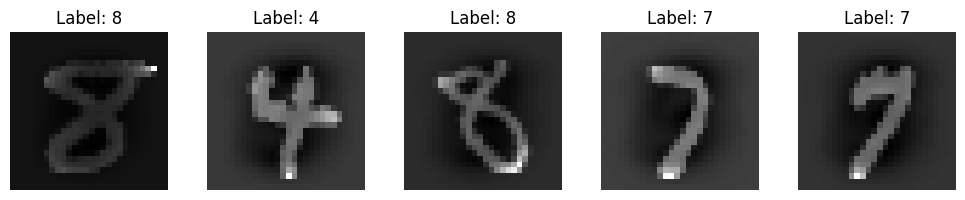

In [5]:
def load_mnist(n_samples=10000, random_state=42):
    """
    Load and preprocess MNIST dataset.

    Parameters:
    -----------
    n_samples : int, default=10000
        Number of samples to load
    random_state : int, default=42
        Random state for reproducibility

    Returns:
    --------
    X : array-like of shape (n_samples, 784)
        The input samples
    y : array-like of shape (n_samples,)
        The target values
    """
    # Load MNIST
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

    # Convert to float32 for faster processing
    X = X.astype('float32')

    # Normalize the data
    X = StandardScaler().fit_transform(X)

    # Subsample if needed
    if n_samples < X.shape[0]:
        np.random.seed(random_state)
        idx = np.random.choice(X.shape[0], n_samples, replace=False)
        X = X[idx]
        y = y[idx]

    return X, y

# Load a subset of MNIST for initial testing
X_mnist, y_mnist = load_mnist(n_samples=1000)

print(f"Loaded MNIST data with shape: {X_mnist.shape}")
print(f"Number of classes: {len(np.unique(y_mnist))}")

# Visualize a few digits to verify the data
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_mnist[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {y_mnist[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

Starting t-SNE embedding...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 7.489475
[t-SNE] Computed conditional probabilities in 0.029s


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Iteration 50: error = 68.1069946, gradient norm = 0.0000001 (50 iterations in 0.196s)
[t-SNE] Iteration 100: error = 68.1069946, gradient norm = 0.0000000 (50 iterations in 0.101s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 100 iterations with early exaggeration: 68.106995
[t-SNE] Iteration 150: error = 1.4221585, gradient norm = 0.0177104 (50 iterations in 0.105s)
[t-SNE] Iteration 200: error = 1.1868703, gradient norm = 0.0116312 (50 iterations in 0.106s)
[t-SNE] Iteration 250: error = 1.1159054, gradient norm = 0.0091850 (50 iterations in 0.122s)
[t-SNE] Iteration 300: error = 1.0848918, gradient norm = 0.0070070 (50 iterations in 0.113s)
[t-SNE] Iteration 350: error = 1.0699525, gradient norm = 0.0055272 (50 iterations in 0.103s)
[t-SNE] Iteration 400: error = 1.0617393, gradient norm = 0.0042232 (50 iterations in 0.118s)
[t-SNE] Iteration 450: error = 1.0571159, gradient norm = 0.0032453 (50 iterations in 0.156s)
[t-SNE] Iteration 

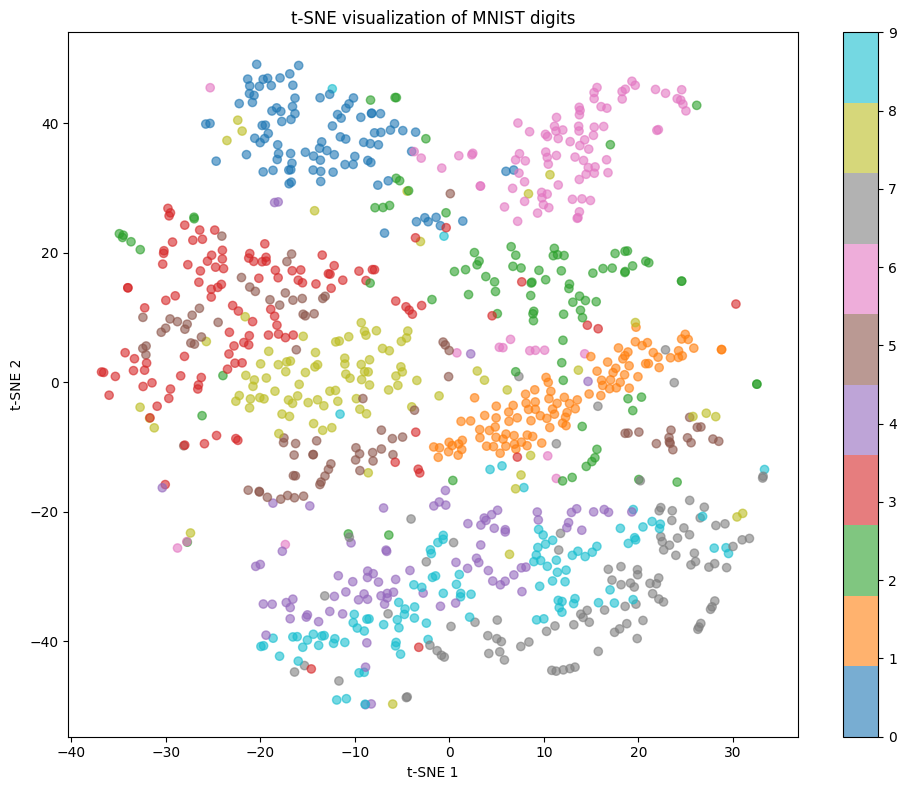

In [8]:
from time import time
from sklearn.manifold import TSNE as SklearnTSNE

def run_euclidean_tsne(X, perplexity=30, n_components=2, random_state=42):
    """
    Run t-SNE in Euclidean space using scikit-learn implementation

    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Input data
    perplexity : float, default=30
        Perplexity parameter for t-SNE
    n_components : int, default=2
        Dimension of the embedded space
    random_state : int, default=42
        Random state for reproducibility

    Returns:
    --------
    X_embedded : array-like of shape (n_samples, n_components)
        Embedded data in lower dimensional space
    """
    tsne = SklearnTSNE(
        n_components=n_components,
        perplexity=perplexity,
        random_state=random_state,
        init='pca',  # Using PCA initialization for better global structure
        learning_rate='auto',
        n_iter=1000,
        verbose=2
    )

    start_time = time()
    X_embedded = tsne.fit_transform(X)
    duration = time() - start_time

    print(f"t-SNE embedding computed in {duration:.2f} seconds")
    return X_embedded

def plot_embedding(X_embedded, y, title=None):
    """
    Plot the embedded data with colors based on labels

    Parameters:
    -----------
    X_embedded : array-like of shape (n_samples, 2)
        Embedded data in 2D
    y : array-like of shape (n_samples,)
        Labels for coloring
    title : str, optional
        Title for the plot
    """
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        X_embedded[:, 0],
        X_embedded[:, 1],
        c=y.astype(int),
        cmap='tab10',
        alpha=0.6
    )
    plt.colorbar(scatter)

    if title is not None:
        plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.tight_layout()
    plt.show()

# Run t-SNE on MNIST data
print("Starting t-SNE embedding...")
X_embedded = run_euclidean_tsne(X_mnist)

# Visualize the t-SNE embedding
plot_embedding(X_embedded, y_mnist, "t-SNE visualization of MNIST digits")

**CO-SNE Visualization on Synthetic Point Clusters (validating hyperbolic implementation)**

Generated 300 points
Starting CO-SNE fitting...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.251343
[HT-SNE] Iteration 50: error = 4.5440424, gradient norm = 0.0156273 (50 iterations in 2.945s)
[HT-SNE] Iteration 100: error = 4.6147340, gradient norm = 0.0156430 (50 iterations in 2.869s)
[HT-SNE] Iteration 150: error = 4.6551328, gradient norm = 0.0158676 (50 iterations in 3.776s)
[HT-SNE] Iteration 200: error = 4.6439099, gradient norm = 0.0154488 (50 iterations in 3.489s)
[HT-SNE] Iteration 250: error = 4.9236794, gradient norm = 0.0168397 (50 iterations in 3.306s)
[HT-SNE] Iteration 300: error = 4.8069057, gradient norm = 0.0154400 (50 iterations in 2.871s)
[HT-SNE] Iteration 350: error = 4.8925470, gradient norm = 0.0148514 (50 iterations in 3.876s)
[HT-SNE] Iteration 400: error = 4.8773783, gradient norm = 0.0143469 (50 iterations in 2.938s)
[HT-SNE] Iteration 450: error = 4.8201278, gradient norm = 0.0165123 (50 iterations in 2.791s)
[HT-S

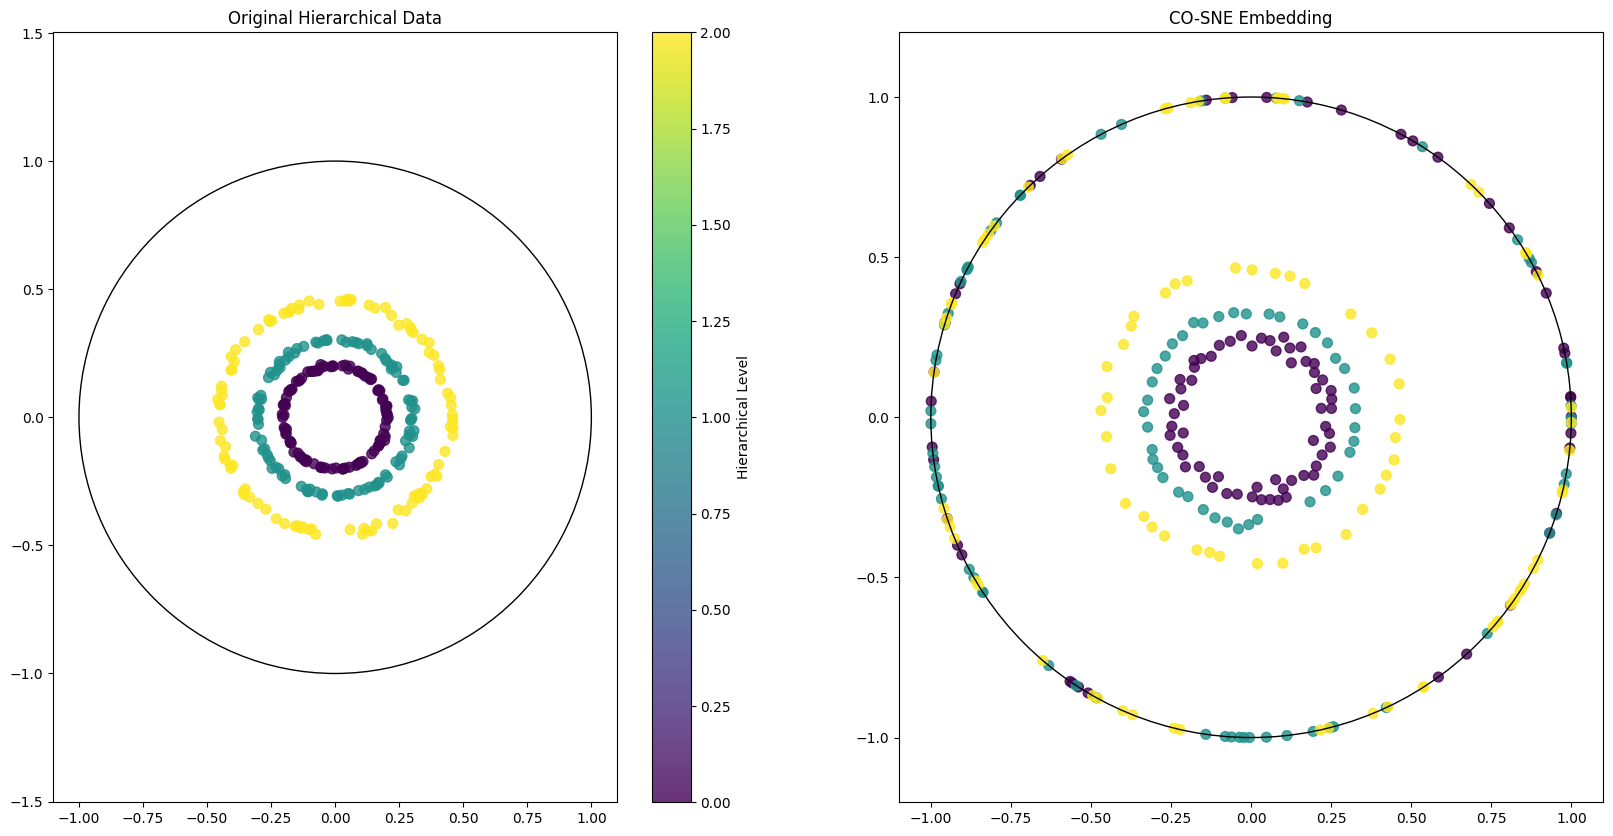

In [12]:
def generate_synthetic_tree_data(n_levels=3, points_per_level=100, noise=0.02):
    """Generate synthetic hierarchical data with clear tree structure."""
    points = []
    labels = []

    # Generate points level by level with increasing radii
    for level in range(n_levels):
        # Radius increases exponentially with level to create clearer hierarchy
        base_radius = 0.2 * (1.5 ** level)

        # Generate points for this level
        angles = np.linspace(0, 2*np.pi, points_per_level) + np.random.normal(0, 0.1, points_per_level)
        radii = base_radius + np.random.normal(0, noise * base_radius, points_per_level)

        # Convert to Cartesian coordinates
        x = radii * np.cos(angles)
        y = radii * np.sin(angles)

        # Add points
        level_points = np.column_stack([x, y])
        points.append(level_points)
        labels.extend([level] * points_per_level)

    X = np.vstack(points)
    y = np.array(labels)

    # Ensure points are within the unit disk
    norms = np.sqrt(np.sum(X**2, axis=1))
    X = X / np.maximum(norms[:, np.newaxis], 0.99)

    return X, y

# Generate synthetic data
X, y = generate_synthetic_tree_data(n_levels=3, points_per_level=100, noise=0.02)

print(f"Generated {len(X)} points")

# Initialize and run CO-SNE with adjusted parameters
cosne = TSNE(
    n_components=2,
    perplexity=50,         # Increased to capture more global structure
    learning_rate=50,      # Reduced for stability
    n_iter=1000,
    method='exact',
    init='random',
    verbose=2,
    early_exaggeration=2.0,  # Reduced early exaggeration
    student_t_gamma=0.1      # Reduced gamma for better hierarchy preservation
)

print("Starting CO-SNE fitting...")
X_embedded = cosne.fit_transform(X, X)
print("CO-SNE fitting completed!")

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot original data
scatter1 = ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50, alpha=0.8)
circle1 = plt.Circle((0, 0), 1, fill=False, color='black')
ax1.add_patch(circle1)
ax1.set_title('Original Hierarchical Data')
ax1.axis('equal')
ax1.set_xlim([-1.1, 1.1])
ax1.set_ylim([-1.1, 1.1])

# Plot CO-SNE embedding
scatter2 = ax2.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', s=50, alpha=0.8)
circle2 = plt.Circle((0, 0), 1, fill=False, color='black')
ax2.add_patch(circle2)
ax2.set_title('CO-SNE Embedding')
ax2.axis('equal')
ax2.set_xlim([-1.1, 1.1])
ax2.set_ylim([-1.1, 1.1])

plt.colorbar(scatter1, label='Hierarchical Level')
plt.show()

In [17]:
class SyntheticDataset(torch.utils.data.Dataset):
    '''
    Implementation of a synthetic dataset by hierarchical diffusion.
    Args:
    :param int dim: dimension of the input sample
    :param int depth: depth of the tree; the root corresponds to the depth 0
    :param int :numberOfChildren: Number of children of each node in the tree
    :param int :numberOfsiblings: Number of noisy observations obtained from the nodes of the tree
    :param float sigma_children: noise
    :param int param: integer by which :math:`\\sigma_children` is divided at each deeper level of the tree
    '''
    def __init__(self, dim, depth, numberOfChildren=2, sigma_children=1, param=1, numberOfsiblings=1, factor_sibling=10):
        self.dim = int(dim)
        self.root = np.zeros(self.dim)
        self.depth = int(depth)
        self.sigma_children = sigma_children
        self.factor_sibling = factor_sibling
        self.param = param
        self.numberOfChildren = int(numberOfChildren)
        self.numberOfsiblings = int(numberOfsiblings)

        self.origin_data, self.origin_labels, self.data, self.labels = self.bst()

        # Normalise data (0 mean, 1 std)
        self.data -= np.mean(self.data, axis=0, keepdims=True)
        self.data /= np.std(self.data, axis=0, keepdims=True)

    def __len__(self):
        '''
        this method returns the total number of samples/nodes
        '''
        return len(self.data)

    def __getitem__(self, idx):
        '''
        Generates one sample
        '''
        data, labels = self.data[idx], self.labels[idx]
        return torch.Tensor(data), torch.Tensor(labels)

    def get_children(self, parent_value, parent_label, current_depth, offspring=True):
        '''
        :param 1d-array parent_value
        :param 1d-array parent_label
        :param int current_depth
        :param  Boolean offspring: if True the parent node gives birth to numberOfChildren nodes
                                    if False the parent node gives birth to numberOfsiblings noisy observations
        :return: list of 2-tuples containing the value and label of each child of a parent node
        :rtype: list of length numberOfChildren
        '''
        if offspring:
            numberOfChildren = self.numberOfChildren
            sigma = self.sigma_children / (self.param ** current_depth)
        else:
            numberOfChildren = self.numberOfsiblings
            sigma = self.sigma_children / (self.factor_sibling*(self.param ** current_depth))
        children = []
        for i in range (numberOfChildren):
            child_value = parent_value + np.random.randn(self.dim) * np.sqrt(sigma)
            child_label = np.copy(parent_label)
            if offspring:
                child_label[current_depth] = i + 1
            else:
                child_label[current_depth] = -i - 1
            children.append((child_value, child_label))
        return children

    def bst(self):
        '''
        This method generates all the nodes of a level before going to the next level
        '''
        queue = [(self.root, np.zeros(self.depth+1), 0)]
        visited = []
        labels_visited = []
        values_clones = []
        labels_clones = []
        while len(queue) > 0:
            current_node, current_label, current_depth = queue.pop(0)
            visited.append(current_node)
            labels_visited.append(current_label)
            if current_depth < self.depth:
                children = self.get_children(current_node, current_label, current_depth)
                for child in children:
                    queue.append((child[0], child[1], current_depth + 1))
            if current_depth <= self.depth:
                clones = self.get_children(current_node, current_label, current_depth, False)
                for clone in clones:
                    values_clones.append(clone[0])
                    labels_clones.append(clone[1])
        length = int(((self.numberOfChildren) ** (self.depth + 1) - 1) / (self.numberOfChildren - 1))
        length_leaves = int(self.numberOfChildren**self.depth)
        images = np.concatenate([i for i in visited]).reshape(length, self.dim)
        labels_visited = np.concatenate([i for i in labels_visited]).reshape(length, self.depth+1)[:,:self.depth]
        values_clones = np.concatenate([i for i in values_clones]).reshape(self.numberOfsiblings*length, self.dim)
        labels_clones = np.concatenate([i for i in labels_clones]).reshape(self.numberOfsiblings*length, self.depth+1)
        return images, labels_visited, values_clones, labels_clones

# Generate synthetic data
sync_data = SyntheticDataset(2, 4)

X = sync_data.data
y = sync_data.labels

print("Show X")
print(X)
print("Show y")
print(y)

print(f"Generated {len(X)} points")

# Initialize and run CO-SNE with adjusted parameters
cosne = TSNE(
    n_components=2,
    perplexity=50,         # Increased to capture more global structure
    learning_rate=50,      # Reduced for stability
    n_iter=1000,
    method='exact',
    init='random',
    verbose=2,
    early_exaggeration=2.0,  # Reduced early exaggeration
    student_t_gamma=0.1      # Reduced gamma for better hierarchy preservation
)

print("Starting CO-SNE fitting...")
X_embedded = cosne.fit_transform(X, X)
print("CO-SNE fitting completed!")

Show X
[[ 0.25592925 -0.50629961]
 [ 0.55903457 -0.42760335]
 [-0.32594623 -0.33916423]
 [-0.04191294 -0.4028351 ]
 [ 0.61645953  0.3808592 ]
 [-1.17938241  0.07920255]
 [ 0.53727578 -0.40665432]
 [-0.46569552 -1.38424089]
 [-0.12445376 -1.03687574]
 [ 1.875574    1.33223888]
 [-0.46096848  0.48414609]
 [-1.57041026  1.12977849]
 [-0.48404572 -1.20353149]
 [ 0.66473725 -0.0199081 ]
 [ 0.97470513 -0.35941315]
 [-0.3643304  -0.97156388]
 [ 0.24548843 -1.59209017]
 [ 0.11611465 -0.05383124]
 [-0.02661183 -0.75676374]
 [ 2.3097267   2.33527847]
 [ 1.72203455  1.38597376]
 [-1.42982969  1.53012737]
 [-1.28743068  0.71583513]
 [-1.60643958  1.53903682]
 [-1.83083969  1.40847146]
 [-0.43810882 -1.09684122]
 [-0.71048016  0.25525337]
 [ 0.74667539 -1.35417657]
 [ 0.66826069 -0.60514517]
 [ 0.53661367 -0.08892879]
 [ 0.51825661  0.02966516]]
Show y
[[-1.  0.  0.  0.  0.]
 [ 1. -1.  0.  0.  0.]
 [ 2. -1.  0.  0.  0.]
 [ 1.  1. -1.  0.  0.]
 [ 1.  2. -1.  0.  0.]
 [ 2.  1. -1.  0.  0.]
 [ 2.  2. 

Starting CO-SNE fitting...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 1.642911
[HT-SNE] Iteration 50: error = 10712910113980.6621094, gradient norm = 0.0102931 (50 iterations in 5.326s)
[HT-SNE] Iteration 100: error = 10712910113976.7773438, gradient norm = 0.0140299 (50 iterations in 5.827s)
[HT-SNE] Iteration 150: error = 10712910113962.2929688, gradient norm = 0.0238827 (50 iterations in 5.842s)
[HT-SNE] Iteration 200: error = 10712910113639.4082031, gradient norm = 10.9929430 (50 iterations in 5.775s)
[HT-SNE] Iteration 250: error = 10712910113663.9023438, gradient norm = 0.0109549 (50 iterations in 6.408s)
[HT-SNE] Iteration 300: error = 10712910112845.7714844, gradient norm = 0.3747368 (50 iterations in 5.730s)
[HT-SNE] Iteration 350: error = 10712910111789.3828125, gradient norm = 0.1529953 (50 iterations in 5.741s)
[HT-SNE] Iteration 400: error = 10712910110459.8984375, gradient norm = 0.1865185 (50 iterations in 5.541s)
[HT-SNE] Iterati

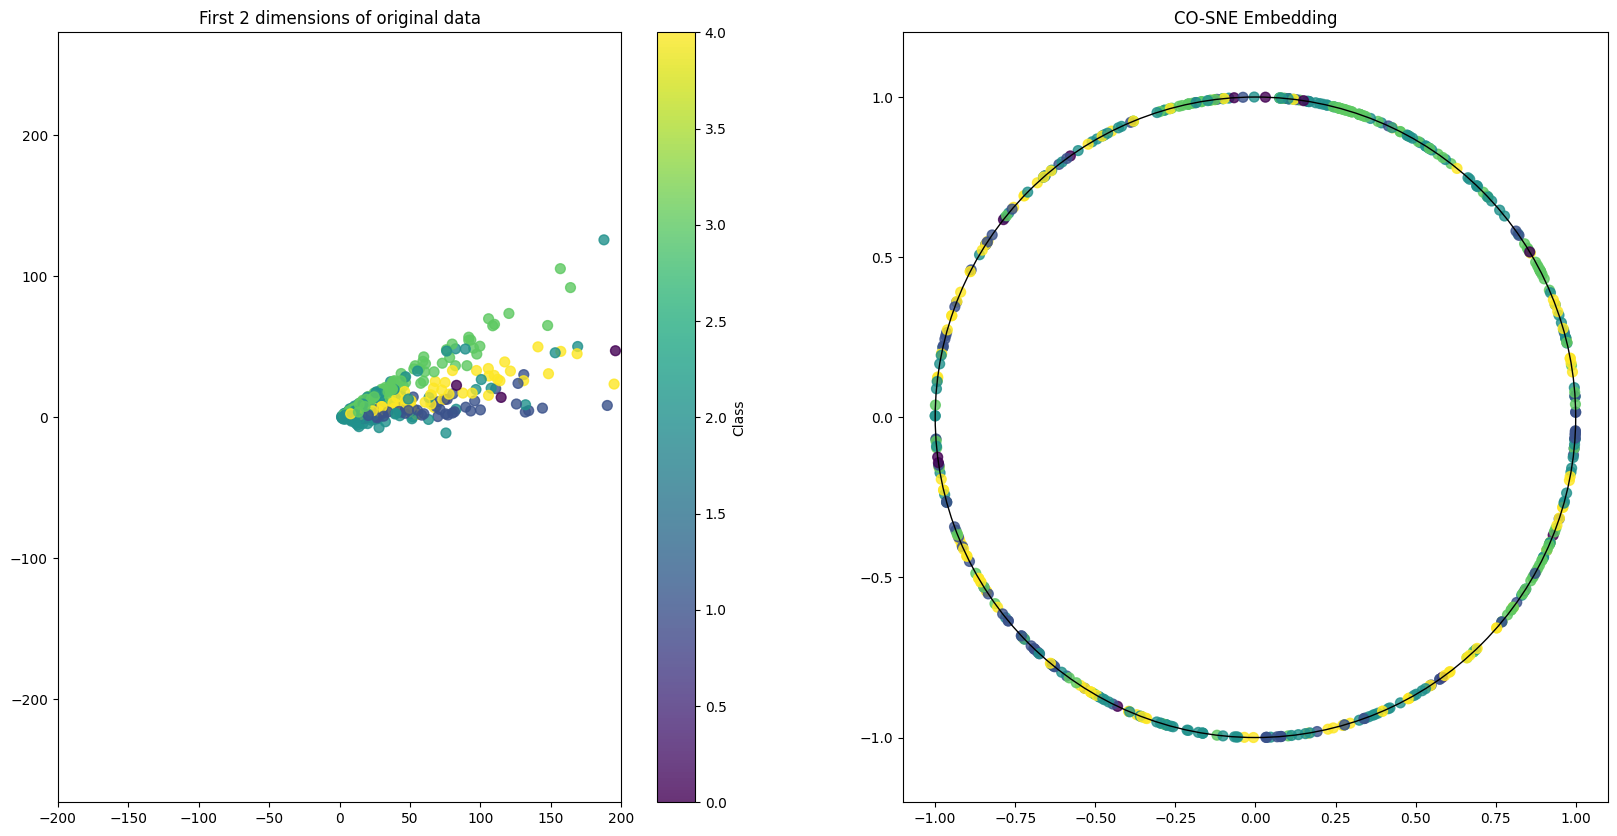

In [18]:
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.hyperboloid import Hyperboloid
from geomstats.geometry.hypersphere import Hypersphere
from scipy.stats import wishart

# Load and preprocess data
product_space = ProductSpace(signature=[(5, -1.0)])
n_samples = 500
n_classes = 5
product_space.sample_clusters(
    num_points=n_samples,
    num_classes=n_classes
)

X = product_space.X
y = product_space.y

# Initialize and run CO-SNE with adjusted parameters
cosne = TSNE(
    n_components=2,
    perplexity=30,         # Increased to capture more global structure
    learning_rate=1,      # Reduced for stability
    learning_rate_for_h_loss=0.01,
    n_iter=1000,
    method='exact',
    init='random',
    verbose=2,
    early_exaggeration=2.0,  # Reduced early exaggeration
    student_t_gamma=0.01      # Reduced gamma for better hierarchy preservation
)

print("Starting CO-SNE fitting...")
X_embedded = cosne.fit_transform(X, X)
print("CO-SNE fitting completed!")

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot original data
scatter1 = ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50, alpha=0.8)
ax1.set_title('First 2 dimensions of original data')
ax1.axis('equal')
ax1.set_xlim([-200, 200])
ax1.set_ylim([-200, 200])

# Plot CO-SNE embedding
scatter2 = ax2.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', s=50, alpha=0.8)
circle2 = plt.Circle((0, 0), 1, fill=False, color='black')
ax2.add_patch(circle2)
ax2.set_title('CO-SNE Embedding')
ax2.axis('equal')
ax2.set_xlim([-1.1, 1.1])
ax2.set_ylim([-1.1, 1.1])

plt.colorbar(scatter1, label='Class')
plt.show()

**Spherical SNE on Wrapped Normal Distribution (establishing spherical visualization)**

In [19]:
def generate_spherical_clusters(n_samples=500, n_clusters=5, kappa=50.0):
    """
    Generate clusters on a sphere using von Mises-Fisher distribution

    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    n_clusters : int
        Number of clusters
    kappa : float
        Concentration parameter (higher = tighter clusters)

    Returns:
    --------
    X : array-like of shape (n_samples, 3)
        Points on the sphere
    y : array-like of shape (n_samples,)
        Cluster labels
    """
    # Initialize manifold
    sphere = Hypersphere(dim=2)  # 2-sphere embedded in R^3

    # Generate cluster centers (randomly on sphere)
    centers = sphere.random_uniform(n_clusters)

    # Generate samples around each center
    samples_per_cluster = n_samples // n_clusters
    X = []
    y = []

    for i in range(n_clusters):
        # Generate points around center using wrapped normal
        wnm = WrappedNormalMixture(
            num_points=samples_per_cluster,
            num_classes=1,
            n_dim=2,
            curvature=1.0,  # positive curvature for sphere
            cov_scale=1.0/kappa
        )

        # Generate points around this center
        points, _, _ = wnm.generate_data()

        X.append(points)
        y.extend([i] * samples_per_cluster)

    X = np.vstack(X)
    y = np.array(y)

    return X, y

# Generate spherical data
print("Generating spherical clusters...")
X_sphere, y_sphere = generate_spherical_clusters()

print("Data shape:", X_sphere.shape)
print("Number of clusters:", len(np.unique(y_sphere)))
print("\nFirst few points:")
print(X_sphere[:5])
print("\nFirst few labels:")
print(y_sphere[:5])

Generating spherical clusters...
Data shape: (500, 3)
Number of clusters: 5

First few points:
[[ 0.2028331  -0.59150103 -0.78037508]
 [ 0.40397098 -0.46025326 -0.79055322]
 [ 0.10726576 -0.63715688 -0.76323336]
 [ 0.25485676 -0.46345278 -0.84868106]
 [ 0.59422703 -0.39003959 -0.70339417]]

First few labels:
[0 0 0 0 0]


In [28]:
def spherical_distance_gradient(x, y):
    """Compute gradient of spherical distance with respect to x."""
    dot_prod = np.dot(x, y)
    # Clip to avoid numerical instability
    dot_prod = np.clip(dot_prod, -1.0 + 1e-7, 1.0 - 1e-7)

    # Gradient of arccos(dot_prod)
    grad = -y / np.sqrt(1 - dot_prod**2)
    # Project gradient onto tangent space
    grad = grad - x * np.dot(x, grad)
    return grad

def compute_joint_probabilities(X, perplexity, verbose=False):
    """
    Compute joint probabilities for spherical t-SNE with progress tracking.
    """
    n_samples = X.shape[0]

    if verbose:
        print("Computing pairwise distances...")

    # Pre-compute all pairwise distances
    distances = np.zeros((n_samples, n_samples))
    for i in tqdm(range(n_samples), disable=not verbose):
        for j in range(i+1, n_samples):
            dist = np.arccos(np.clip(np.dot(X[i], X[j]), -1.0 + 1e-7, 1.0 - 1e-7))
            distances[i, j] = dist
            distances[j, i] = dist

    if verbose:
        print("Computing probabilities...")

    # Convert distances to probabilities
    P = np.zeros((n_samples, n_samples))
    beta = np.ones(n_samples)
    desired_entropy = np.log(perplexity)

    # Binary search for sigma (beta)
    for i in tqdm(range(n_samples), disable=not verbose):
        beta_min = -np.inf
        beta_max = np.inf

        for _ in range(20):  # Reduced max iterations for binary search
            # Compute conditional probabilities
            dist_i = distances[i]
            exp_dist = np.exp(-dist_i * beta[i])
            exp_dist[i] = 0
            sum_exp_dist = np.sum(exp_dist)

            if sum_exp_dist == 0:
                P[i] = np.zeros(n_samples)
                P[i, i] = 0
                break

            P[i] = exp_dist / sum_exp_dist

            # Compute entropy
            entropy = -np.sum(P[i] * np.log2(P[i] + 1e-7))

            # Binary search update
            entropy_diff = entropy - desired_entropy
            if np.abs(entropy_diff) < 1e-5:
                break

            if entropy_diff > 0:
                beta_min = beta[i]
                if beta_max == np.inf:
                    beta[i] = beta[i] * 2
                else:
                    beta[i] = (beta[i] + beta_max) / 2
            else:
                beta_max = beta[i]
                if beta_min == -np.inf:
                    beta[i] = beta[i] / 2
                else:
                    beta[i] = (beta[i] + beta_min) / 2

    # Symmetrize P
    P = (P + P.T) / (2 * n_samples)
    P = np.maximum(P, 1e-12)

    if verbose:
        print("Joint probability computation completed!")

    return P

class SphericalTSNE(TSNE):
    def __init__(self, n_components=3, perplexity=30.0, early_exaggeration=12.0,
                 learning_rate=200.0, n_iter=1000, n_iter_without_progress=300,
                 min_grad_norm=1e-7, metric="precomputed", init="random",
                 verbose=0, random_state=None, method='exact', angle=0.5,
                 n_jobs=None):
        super().__init__(
            n_components=n_components,
            perplexity=perplexity,
            early_exaggeration=early_exaggeration,
            learning_rate=learning_rate,
            n_iter=n_iter,
            n_iter_without_progress=n_iter_without_progress,
            min_grad_norm=min_grad_norm,
            metric=metric,
            init=init,
            verbose=verbose,
            random_state=random_state,
            method=method,
            angle=angle,
            n_jobs=n_jobs
        )

    def _compute_gradients(self, X_embedded, P):
        """Vectorized gradient computation"""
        n_samples = X_embedded.shape[0]

        # Compute all pairwise dot products
        dots = np.dot(X_embedded, X_embedded.T)
        np.fill_diagonal(dots, 1.0)  # Avoid numerical issues
        dots = np.clip(dots, -1.0 + 1e-7, 1.0 - 1e-7)

        # Compute distances
        dists = np.arccos(dots)

        # Compute Q matrix
        Q = 1.0 / (1.0 + dists**2)
        np.fill_diagonal(Q, 0.0)
        Q = Q / np.sum(Q)

        # Compute gradient
        PQ_diff = P - Q
        grad = np.zeros_like(X_embedded)

        for i in range(n_samples):
            # Compute gradients for point i
            grad_coef = 2 * PQ_diff[i] * Q[i]

            # Compute direction vectors
            directions = X_embedded[i:i+1] - X_embedded

            # Project onto tangent space
            proj = np.sum(directions * X_embedded, axis=1, keepdims=True)
            directions = directions - proj * X_embedded

            # Weight by coefficients
            grad[i] = np.sum(grad_coef[:, np.newaxis] * directions, axis=0)

        return grad

    def _spherical_gradient_descent(self, X, P, n_iter):
        """Optimized gradient descent for spherical manifold."""
        X_embedded = X.copy()

        for iteration in tqdm(range(n_iter), desc="Optimization progress"):
            # Compute gradients
            grad = self._compute_gradients(X_embedded, P)

            # Update points
            X_embedded = X_embedded - self.learning_rate * grad

            # Project back to sphere
            X_embedded = X_embedded / np.linalg.norm(X_embedded, axis=1)[:, None]

        return X_embedded

    def _fit(self, X, embs, skip_num_points=0):
        """Same as before"""
        if self.verbose:
            print("Starting spherical t-SNE fitting...")

        P = compute_joint_probabilities(X, self.perplexity, self.verbose)

        random_state = check_random_state(self.random_state)
        X_embedded = random_state.randn(X.shape[0], 3)
        X_embedded = X_embedded / np.linalg.norm(X_embedded, axis=1)[:, None]

        X_embedded = self._spherical_gradient_descent(X_embedded, P, self.n_iter)

        return X_embedded

# Test the implementation
print("Fitting Spherical t-SNE...")
spherical_tsne = SphericalTSNE(
    n_components=3,
    perplexity=30,
    learning_rate=100,
    n_iter=1000,
    verbose=True
)

X_embedded = spherical_tsne.fit_transform(X_sphere, X_sphere)
print("\nEmbedding shape:", X_embedded.shape)
print("Sample embedded points:")
print(X_embedded[:5])

Fitting Spherical t-SNE...
Starting spherical t-SNE fitting...
Computing pairwise distances...


100%|██████████| 500/500 [00:00<00:00, 504.28it/s]


Computing probabilities...


100%|██████████| 500/500 [00:00<00:00, 1539.68it/s]


Joint probability computation completed!


Optimization progress: 100%|██████████| 1000/1000 [00:39<00:00, 25.04it/s]


Embedding shape: (500, 3)
Sample embedded points:
[[-0.07885102  0.47403617 -0.87696763]
 [ 0.80403916  0.15079679  0.57513594]
 [-0.59869141 -0.07799409 -0.79717345]
 [ 0.64985759 -0.53334375 -0.54150675]
 [-0.97405477  0.22340659  0.03614968]]


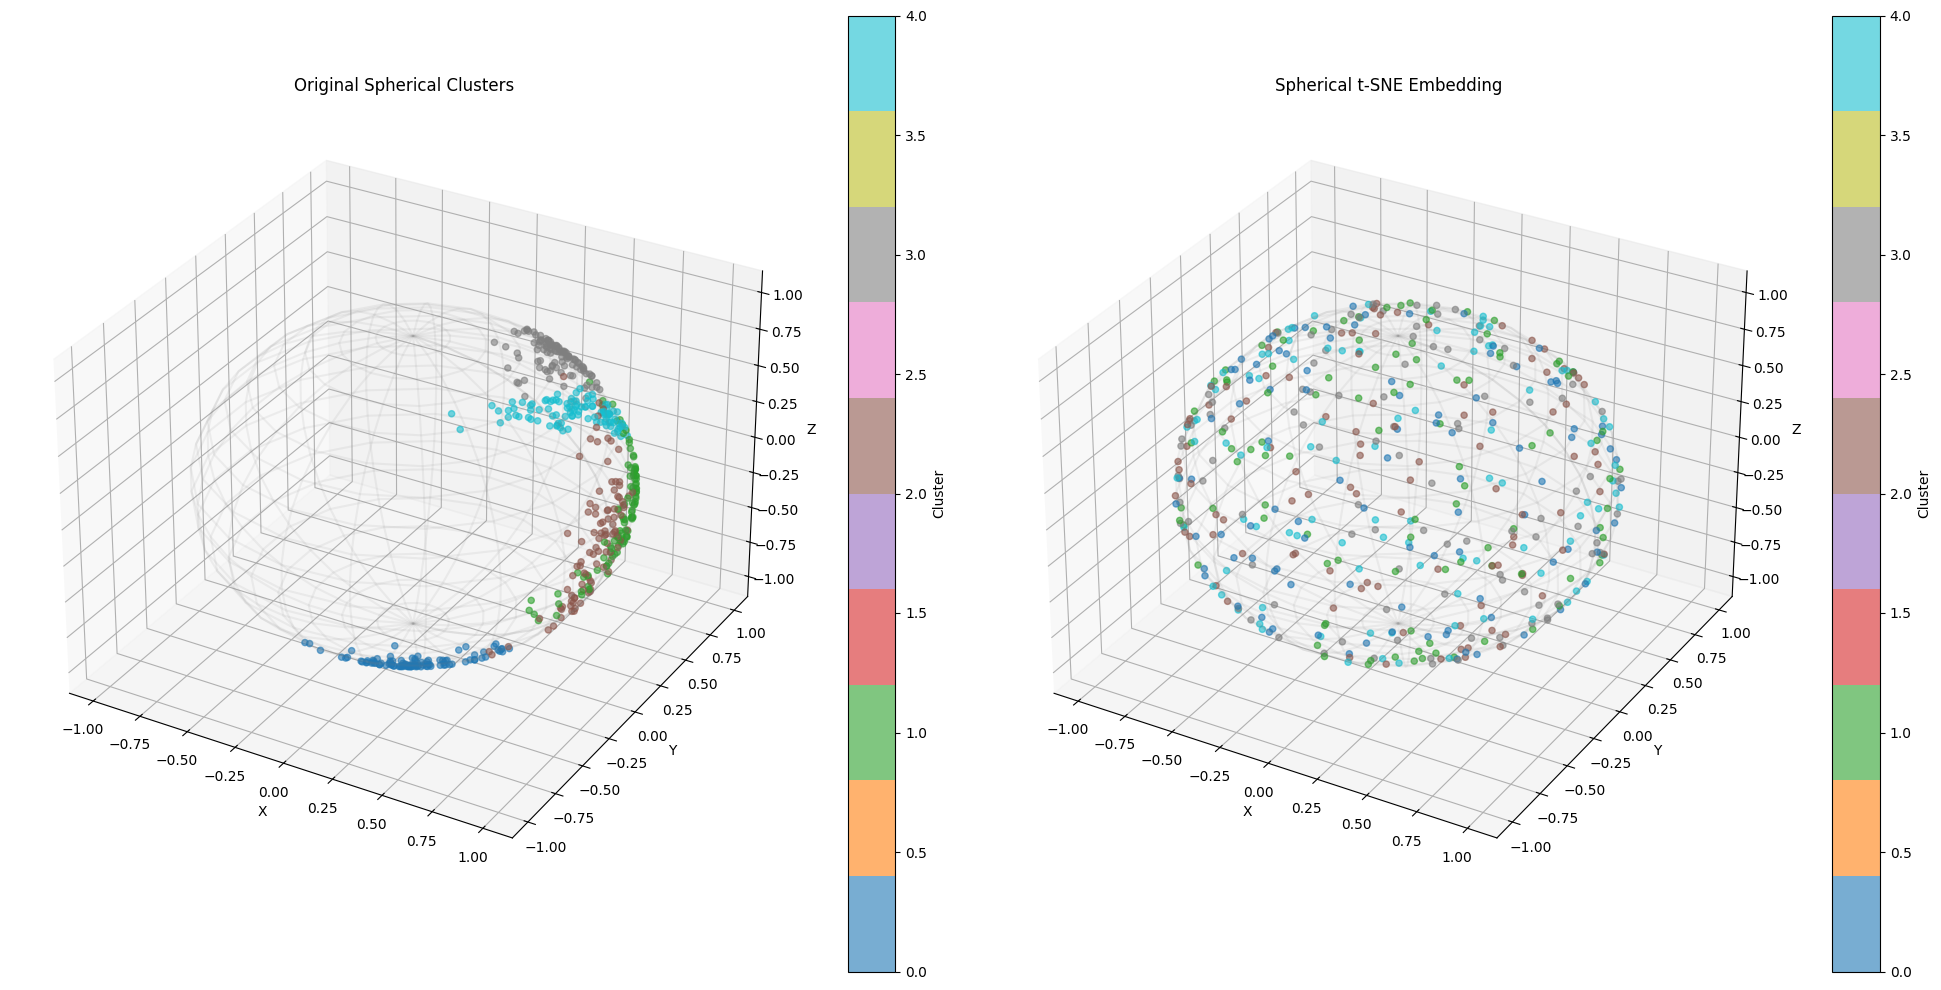


Cluster preservation metrics:
Original silhouette score: 0.441
Embedded silhouette score: -0.044


In [29]:
def plot_3d_scatter(points, labels, title, ax=None):
    """
    Plot 3D scatter plot of points on a sphere with a wireframe sphere for reference.
    """
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

    # Plot points
    scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                        c=labels, cmap='tab10', alpha=0.6)

    # Add wireframe sphere
    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x, y, z, color='gray', alpha=0.1)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)

    return scatter

# Create figure with two subplots
fig = plt.figure(figsize=(20, 10))

# Plot original data
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = plot_3d_scatter(X_sphere, y_sphere, 'Original Spherical Clusters', ax1)
plt.colorbar(scatter1, label='Cluster')

# Plot t-SNE embedding
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = plot_3d_scatter(X_embedded, y_sphere, 'Spherical t-SNE Embedding', ax2)
plt.colorbar(scatter2, label='Cluster')

# Adjust layout
plt.tight_layout()
plt.show()

# Print some statistics about cluster preservation
from sklearn.metrics import silhouette_score

# Compute silhouette scores for both original and embedded data
original_score = silhouette_score(X_sphere, y_sphere, metric='cosine')
embedded_score = silhouette_score(X_embedded, y_sphere, metric='cosine')

print("\nCluster preservation metrics:")
print(f"Original silhouette score: {original_score:.3f}")
print(f"Embedded silhouette score: {embedded_score:.3f}")

**Decomposed Visualization of Mixed-Curvature Data (S² × E² × H²)**

In [57]:
# Generate mixed-curvature data using ProductSpace
print("Generating mixed-curvature data (S² × E² × H²)...")

# Create product space with all three geometries
product_space = ProductSpace(signature=[
    (2, 1.0),   # S² component (positive curvature)
    (2, 0.0),   # E² component (zero curvature)
    (2, -1.0)   # H² component (negative curvature)
])

# Generate data with more separated clusters
n_samples = 500
n_classes = 5
product_space.sample_clusters(
    num_points=n_samples,
    num_classes=n_classes,
    cov_scale=0.05  # Reduced from 0.1 for tighter clusters
)

# Split the data into its geometric components
X = product_space.X
y = product_space.y

# Extract components
X_spherical = X[:, :3]      # First 3 dimensions (S²)
X_euclidean = X[:, 3:5]     # Next 2 dimensions (E²)
X_hyperbolic = X[:, 5:]     # Last 3 dimensions (H²)

# Project hyperbolic points onto hyperboloid
def project_to_hyperboloid(X):
    """Project points onto the hyperboloid x₀² - x₁² - x₂² - x₃² = 1, x₀ > 0"""
    spatial_norm = np.sqrt(np.sum(X[:, 1:]**2, axis=1))
    x0 = np.sqrt(1 + spatial_norm**2)
    X_proj = np.column_stack([x0, X[:, 1:]])
    return X_proj

X_hyperbolic = project_to_hyperboloid(X_hyperbolic)

print("\nData shapes:")
print(f"Full data: {X.shape}")
print(f"Spherical component: {X_spherical.shape}")
print(f"Euclidean component: {X_euclidean.shape}")
print(f"Hyperbolic component: {X_hyperbolic.shape}")

# Verify geometric constraints
print("\nVerifying geometric constraints:")
print(f"Spherical points on unit sphere: {np.allclose(np.linalg.norm(X_spherical, axis=1), 1.0)}")
print(f"Hyperbolic points on hyperboloid: {np.allclose(X_hyperbolic[:, 0]**2 - np.sum(X_hyperbolic[:, 1:]**2, axis=1), 1.0, rtol=1e-5)}")
print(f"Hyperbolic points have positive x₀: {np.all(X_hyperbolic[:, 0] > 0)}")

# Show sample points from each component
print("\nSample points from each geometry:")
print("Spherical:")
print(X_spherical[:3])
print("\nEuclidean:")
print(X_euclidean[:3])
print("\nHyperbolic:")
print(X_hyperbolic[:3])

# Additional verification of geometric properties
print("\nAdditional geometric properties:")
print(f"Mean spherical radius: {np.mean(np.linalg.norm(X_spherical, axis=1)):.6f}")
print(f"Mean hyperbolic x₀: {np.mean(X_hyperbolic[:, 0]):.6f}")
print(f"Mean Euclidean norm: {np.mean(np.linalg.norm(X_euclidean, axis=1)):.6f}")

Generating mixed-curvature data (S² × E² × H²)...

Data shapes:
Full data: (500, 9)
Spherical component: (500, 3)
Euclidean component: (500, 2)
Hyperbolic component: (500, 4)

Verifying geometric constraints:
Spherical points on unit sphere: True
Hyperbolic points on hyperboloid: True
Hyperbolic points have positive x₀: True

Sample points from each geometry:
Spherical:
[[-0.92453376 -0.25524406 -0.28299787]
 [ 0.48387904  0.68846874 -0.54025167]
 [-0.33328978 -0.71157124  0.61853399]]

Euclidean:
[[1.         0.3118488 ]
 [1.         1.55773498]
 [1.         0.45332974]]

Hyperbolic:
[[ 3.63978344  2.57371555  2.3486397   0.32848636]
 [ 3.6969917   2.6141679  -1.8644306   1.53550394]
 [ 5.6554445   3.99900316 -0.23650433  3.86472405]]

Additional geometric properties:
Mean spherical radius: 1.000000
Mean hyperbolic x₀: 2.791690
Mean Euclidean norm: 1.320741



Fitting Spherical t-SNE...


Optimization progress: 100%|██████████| 1000/1000 [00:45<00:00, 21.99it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Fitting Euclidean t-SNE...
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.043084
[t-SNE] KL divergence after 250 iterations with early exaggeration: 8.356256
[t-SNE] KL divergence after 2000 iterations: 0.150422

Fitting CO-SNE...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.332807
[HT-SNE] Iteration 50: error = 396.8035050, gradient norm = 0.1032669 (50 iterations in 5.358s)
[HT-SNE] Iteration 100: error = 396.7415364, gradient norm = 0.1094827 (50 iterations in 5.845s)
[HT-SNE] Iteration 150: error = 396.7700050, gradient norm = 0.1090271 (50 iterations in 5.328s)
[HT-SNE] Iteration 200: error = 396.7611648, gradient norm = 0.1072759 (50 iterations in 5.833s)
[HT-SNE] Iteration 250: error = 396.7394410, gradient norm = 0.1214482 (50 iterations in 5.320s)
[HT-SNE] Iter

<Figure size 2000x600 with 0 Axes>

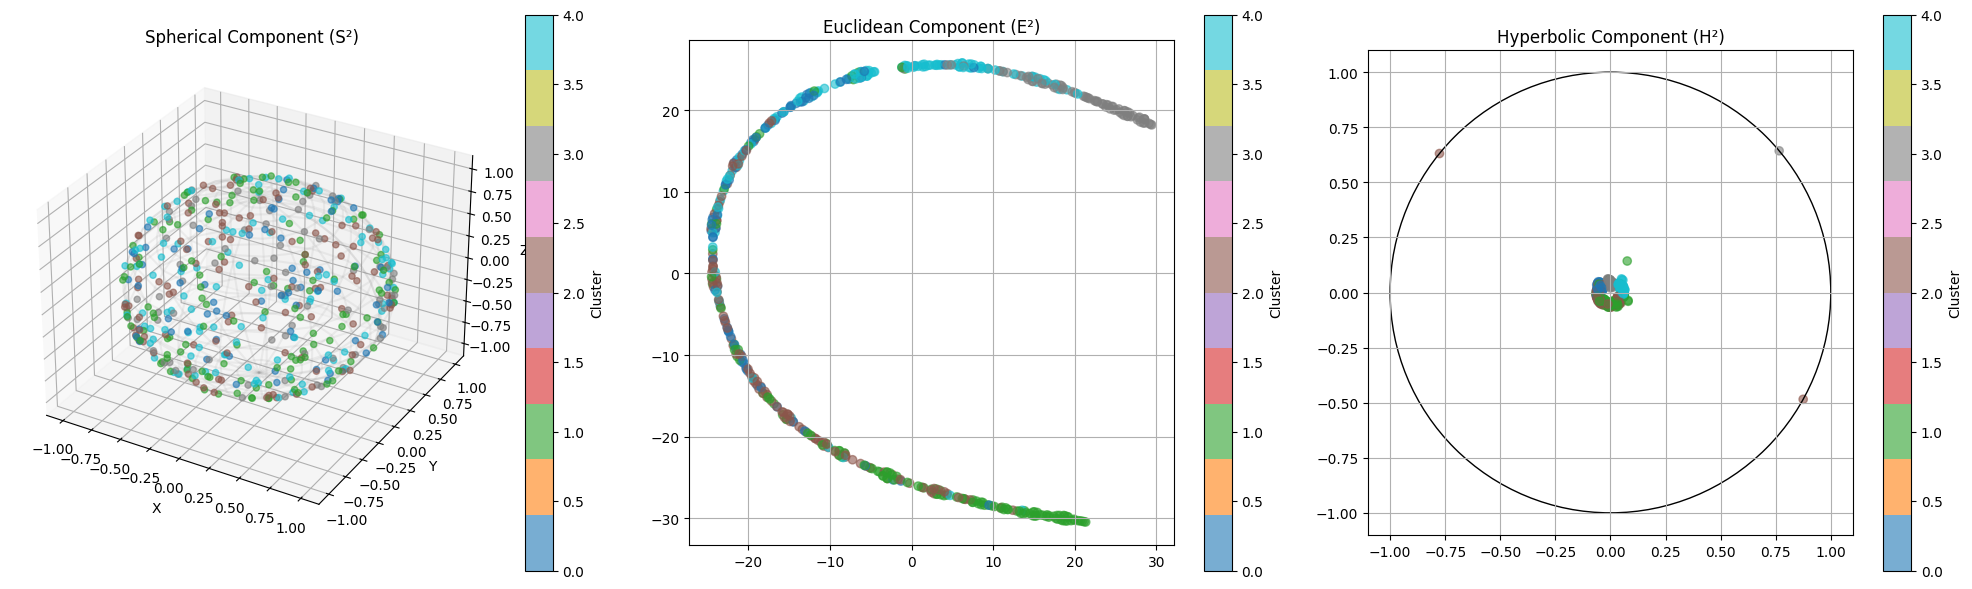


Clustering quality metrics:
Silhouette scores (higher is better, range [-1, 1]):
Spherical component: -0.029
Euclidean component: 0.100
Hyperbolic component: 0.283

Calinski-Harabasz scores (higher is better):
Spherical component: 0.493
Euclidean component: 189.175
Hyperbolic component: 38.089


In [58]:
# Set up the visualization
fig = plt.figure(figsize=(20, 6))

# Normalize/scale the components before embedding
X_spherical_norm = X_spherical / np.linalg.norm(X_spherical, axis=1)[:, None]
X_euclidean_scaled = StandardScaler().fit_transform(X_euclidean)

# Set up the visualization
fig = plt.figure(figsize=(20, 6))

# 1. Spherical Component
print("\nFitting Spherical t-SNE...")
spherical_tsne = SphericalTSNE(
    n_components=3,
    perplexity=25,        # Reduced perplexity
    learning_rate=25,     # Further reduced learning rate
    n_iter=1000,
    verbose=False
)
X_spherical_embedded = spherical_tsne.fit_transform(X_spherical_norm, X_spherical_norm)

# 2. Euclidean Component
print("\nFitting Euclidean t-SNE...")
euclidean_tsne = SklearnTSNE(
    n_components=2,
    perplexity=25,        # Reduced perplexity
    learning_rate=200,    # Increased learning rate
    init='random',        # Changed to random init
    early_exaggeration=4.0,
    n_iter=2000,
    verbose=1
)
X_euclidean_embedded = euclidean_tsne.fit_transform(X_euclidean_scaled)

# 3. Hyperbolic Component
print("\nFitting CO-SNE...")
cosne = TSNE(
    n_components=2,
    perplexity=25,
    learning_rate=5,
    learning_rate_for_h_loss=0.0001,
    n_iter=1000,
    method='exact',
    init='random',
    verbose=2,
    early_exaggeration=2.0,
    student_t_gamma=0.5
)
X_hyperbolic_embedded = cosne.fit_transform(X_hyperbolic, X_hyperbolic)
print("CO-SNE completed!")

# Visualize all three embeddings
print("\nCreating visualizations...")

ax1 = fig.add_subplot(131, projection='3d')
scatter1 = plot_3d_scatter(X_spherical_embedded, y, 'Spherical Component (S²)', ax1)

ax2 = fig.add_subplot(132)
scatter2 = plt.scatter(X_euclidean_embedded[:, 0], X_euclidean_embedded[:, 1],
                      c=y, cmap='tab10', alpha=0.6)
plt.title('Euclidean Component (E²)')
ax2.set_aspect('equal')
plt.grid(True)

ax3 = fig.add_subplot(133)
scatter3 = plt.scatter(X_hyperbolic_embedded[:, 0], X_hyperbolic_embedded[:, 1],
                      c=y, cmap='tab10', alpha=0.6)
circle = plt.Circle((0, 0), 1, fill=False, color='black')
ax3.add_patch(circle)
plt.title('Hyperbolic Component (H²)')
ax3.set_aspect('equal')
plt.grid(True)

# Add colorbar
plt.colorbar(scatter1, label='Cluster', ax=ax1)
plt.colorbar(scatter2, label='Cluster', ax=ax2)
plt.colorbar(scatter3, label='Cluster', ax=ax3)

plt.tight_layout()
plt.show()

# Print clustering quality metrics for each embedding
from sklearn.metrics import silhouette_score, calinski_harabasz_score

print("\nClustering quality metrics:")
print("Silhouette scores (higher is better, range [-1, 1]):")
print(f"Spherical component: {silhouette_score(X_spherical_embedded, y, metric='euclidean'):.3f}")
print(f"Euclidean component: {silhouette_score(X_euclidean_embedded, y, metric='euclidean'):.3f}")
print(f"Hyperbolic component: {silhouette_score(X_hyperbolic_embedded, y, metric='euclidean'):.3f}")

print("\nCalinski-Harabasz scores (higher is better):")
print(f"Spherical component: {calinski_harabasz_score(X_spherical_embedded, y):.3f}")
print(f"Euclidean component: {calinski_harabasz_score(X_euclidean_embedded, y):.3f}")
print(f"Hyperbolic component: {calinski_harabasz_score(X_hyperbolic_embedded, y):.3f}")

**Section 4** (Spherical SNE): Current implementation shows poor clustering, might need refinement in implementation or parameters?

**Section 5** (Mixed-Curvature Visualization): The current approach uses the same clustering approach for all geometries, we might need to generate data that better highlights each geometry's strengths. Or should we be standardizing the data generation across all geometries using the ProductSpace class (similar to what we did in the third cell of Section 3)?